In [1]:
import sys
import json
import nltk
import re
from collections import Counter
import string
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from nltk import bigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm
import numpy as np
import math
import statistics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sppag\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
filename = "Reddit_T20_data.json"

In [4]:
# loading the data

with open(filename, "r") as f:
    reddit_data = json.load(f)

In [5]:
# oldest was newest post time

oldest = reddit_data['submissions'][0].get("created_utc")
newest = reddit_data['submissions'][0].get("created_utc")

for post in reddit_data['submissions']:
    posted_time = post.get("created_utc")
    if posted_time > newest:
        newest = posted_time
    elif posted_time < oldest:
        oldest = posted_time

oldest = datetime.fromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S')
newest = datetime.fromtimestamp(newest).strftime('%Y-%m-%d %H:%M:%S')

print(f"Oldest post time : {oldest}")
print(f"Newest post time : {newest}")

Oldest post time : 2020-03-08 20:54:54
Newest post time : 2024-09-27 12:07:05


In [6]:
# filterting data : created after '2023-12-01'
filtered=[]
for post in reddit_data['submissions']:
    posted_time = post.get("created_utc")
    posted_time = datetime.fromtimestamp(posted_time).strftime('%Y-%m-%d %H:%M:%S')
    
    if posted_time>'2023-12-01 00:00:00':
        filtered.append(post)

In [7]:
# calculating no of posts and comments
no_posts = 0
no_comments = 0

for post in filtered:
    no_posts +=1
    
    for comment in post['comments']:
        no_comments += 1

In [8]:
# observing no of posts and comments
print(f"No of posts : {no_posts}")
print(f"No of comments : {no_comments}")
print(f"Total data : {no_posts + no_comments}")

No of posts : 146
No of comments : 79187
Total data : 79333


In [9]:
# no of posts without body
post_body = 0

for post in filtered:
    body = post["body"]
    if body =="":
        post_body +=1

print(f"No of posts without body : {post_body}")

No of posts without body : 120


In [10]:
# observing post body
for post in filtered:
    if post['body']!="":
        print(post['body'])

My name is Jimmy O'Brien. In 2017 I started a New York Yankees podcast and making content around MLB. What began as a hobby has grown into a business, as Jomboy Media now has 50+ employees, 40+ shows, and over 100+ social accounts. 

In 2021 my son was born, which meant I was awake at all hours of the night and the only sport on at 3AM was Cricket. I got hooked and haven't stopped watching since.  

I will begin answering the questions tomorrow (19th of June) at around 9 AM EST

  
[proof](https://imgur.com/a/VTc99P1)
Obviously I'm happy with the result, but even in a totally unbiased way - I think this was a carnival of a world cup, way better than recent years. One of the best ever in terms of atmosphere and results, despite the crazy day games forced upon the players.

**You guys can call me out - was it only because I followed this one a lot more closely? My take:**

* **2021 WC:** the less said about ***toss cup***, the better.
* **2022** was a better atmosphere than 2021 but not 

In [11]:
# converting data into a dataframe
reddit_t20 = []

for post in filtered:
    post_id = post.get('id')
    post_title = post.get('title')
    post_author = post.get("author")
    post_score = post.get("score")
    post_time = post.get("created_utc")
    post_time = datetime.fromtimestamp(post_time).strftime('%Y-%m-%d %H:%M:%S')
    no_comments = len(post.get('comments'))
    data_type = "Post"
    
    reddit_t20.append({
        'Post_id':post_id,
        'Id':post_id,
        'Time': post_time,
        'Author': post_author,
        'Score':post_score,
        'No_comments': no_comments,
        'Body' : post_title,
        'Type' : data_type
    })
    
    for comment in post['comments']:
        comment_id = comment.get("comment_id")
        comment_time = comment.get("comment_time")
        comment_time = datetime.fromtimestamp(comment_time).strftime('%Y-%m-%d %H:%M:%S')
        comment_author = comment.get("comment_author")
        comment_score = comment.get("comment_score")
        comment_body = comment.get("comment_body")
        
        reddit_t20.append({
        'Post_id':post_id,    
        'Id':comment_id,
        'Time': comment_time,
        'Author': comment_author,
        'Score':comment_score,
        'No_comments': None,
        'Body' : comment_body,
        'Type' : "Comment"
    }) 


In [12]:
reddit_t20_df = pd.DataFrame(reddit_t20)

In [13]:
reddit_t20_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222.0,India are the champions of T20 World Cup 2024,Post
1,1drh232,lav528s,2024-06-30 04:04:36,AssociationNo9219,2969,NaN,The death over bowling from India when 30 of 3...,Comment
2,1drh232,lav4wrb,2024-06-30 04:03:41,sherlockwm,1324,NaN,South Africa had just sniffed the cup and Indi...,Comment
3,1drh232,lav55k3,2024-06-30 04:05:11,ghazilazi,1736,NaN,I have no idea how India managed to come back ...,Comment
4,1drh232,lav5kim,2024-06-30 04:07:49,Rytnix07,550,NaN,The cruelty of sport. The two teams which came...,Comment


In [14]:
reddit_t20_df.shape

(79333, 8)

In [15]:
pd.set_option('display.max_colwidth', None)

In [16]:
reddit_t20_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79333 entries, 0 to 79332
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Post_id      79333 non-null  object 
 1   Id           79333 non-null  object 
 2   Time         79333 non-null  object 
 3   Author       79333 non-null  object 
 4   Score        79333 non-null  int64  
 5   No_comments  146 non-null    float64
 6   Body         79333 non-null  object 
 7   Type         79333 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 4.8+ MB


In [17]:
# correcting data types
reddit_t20_df['Time']=pd.to_datetime(reddit_t20_df['Time'])
reddit_t20_df['No_comments']=reddit_t20_df['No_comments'].fillna(0).astype(int)

In [18]:
reddit_t20_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79333 entries, 0 to 79332
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Post_id      79333 non-null  object        
 1   Id           79333 non-null  object        
 2   Time         79333 non-null  datetime64[ns]
 3   Author       79333 non-null  object        
 4   Score        79333 non-null  int64         
 5   No_comments  79333 non-null  int32         
 6   Body         79333 non-null  object        
 7   Type         79333 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(5)
memory usage: 4.5+ MB


In [19]:
reddit_t20_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post
1,1drh232,lav528s,2024-06-30 04:04:36,AssociationNo9219,2969,0,The death over bowling from India when 30 of 30 was needed is the type of nerves we needed under pressure,Comment
2,1drh232,lav4wrb,2024-06-30 04:03:41,sherlockwm,1324,0,South Africa had just sniffed the cup and India took it away,Comment
3,1drh232,lav55k3,2024-06-30 04:05:11,ghazilazi,1736,0,"I have no idea how India managed to come back from 30(30), but Jasprit Bumrah is a cheat code.",Comment
4,1drh232,lav5kim,2024-06-30 04:07:49,Rytnix07,550,0,"The cruelty of sport. The two teams which came to the final were in drought for an ICC trophy. As an Indian I am overjoyed, and congrats to SA for such an amazing battle. \n\nSeeing Miller cry broke my heart, Stand proud SA you played so well.",Comment


In [20]:
grouped_by_date = reddit_t20_df.groupby(reddit_t20_df['Time'].dt.date).size()

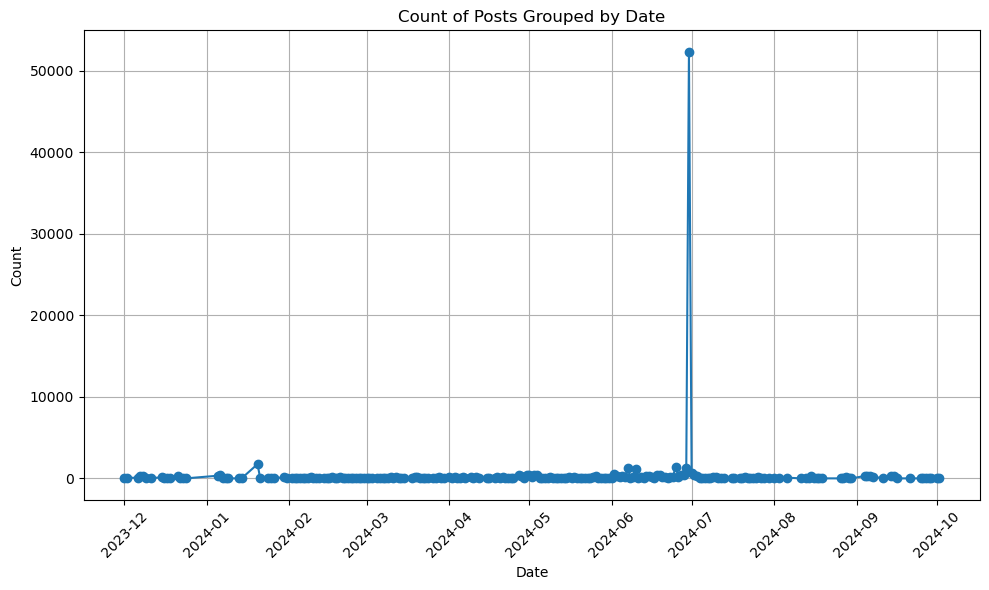

In [21]:
# plotting resutls
plt.figure(figsize=(10, 6))
grouped_by_date.plot(kind='line', marker='o')  
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count of Posts Grouped by Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# date for higher comments
grouped_by_date[grouped_by_date > 10000]

Time
2024-06-30    52344
dtype: int64

In [23]:
# post with more than 10000 comments
reddit_t20_df[reddit_t20_df['No_comments']>10000]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
24525,1drb4pt,1drb4pt,2024-06-29 23:24:26,CricketMatchBot,3133,50589,Match Thread: Final - India vs South Africa,Post


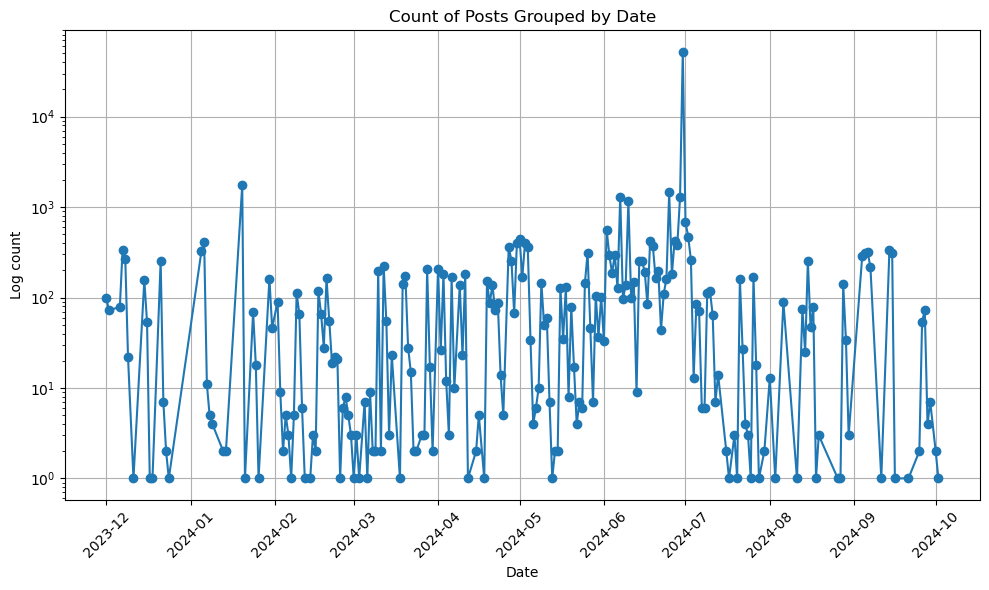

In [24]:
# plotting resutls log scale
plt.figure(figsize=(10, 6))
grouped_by_date.plot(kind='line', marker='o')
plt.xlabel('Date')
plt.ylabel('Log count')
plt.title('Count of Posts Grouped by Date')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# without post 1drb4pt and related comments
filtered_posts = reddit_t20_df[reddit_t20_df['Post_id'] != '1drb4pt']
filtered_posts.shape

(28743, 8)

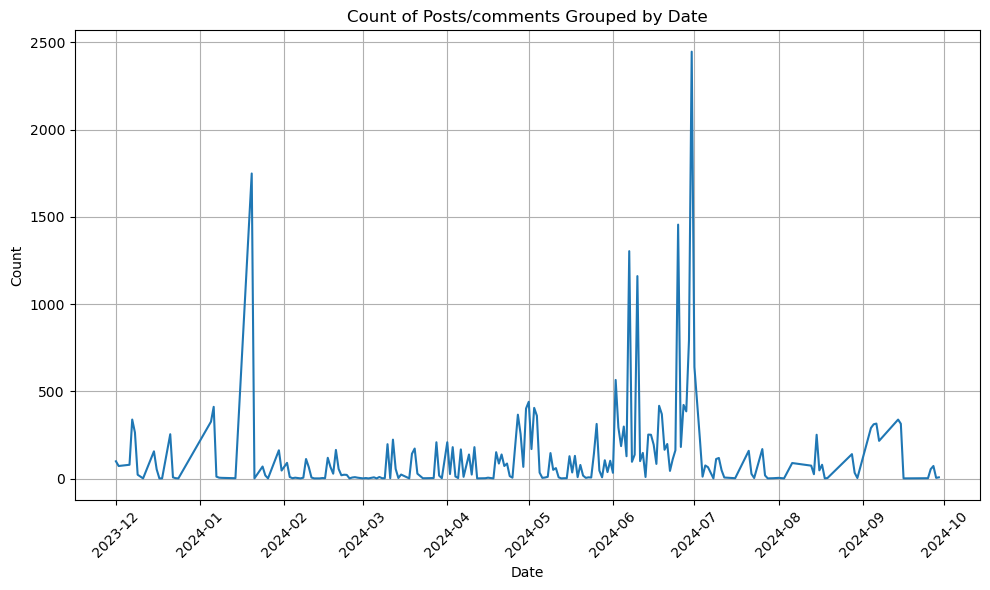

In [26]:
o_grouped_by_date = filtered_posts.groupby(filtered_posts['Time'].dt.date).size()

plt.figure(figsize=(10, 6))
o_grouped_by_date.plot(kind='line')  
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count of Posts/comments Grouped by Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# posts with more than 500 comments
filtered_posts[filtered_posts['No_comments']>500]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post
1223,1dny3w0,1dny3w0,2024-06-25 15:07:29,ICumCoffee,4691,703,Afghanistan makes history and qualify for the Semi-Final of 2024 T20 World Cup; their first ever. They will face South Africa in the 1st Semi-Final,Post
1927,1dny8mp,1dny8mp,2024-06-25 15:16:00,ll--o--ll,2215,653,"WTC 2023 and ODI WC 2023 Champions, Australia, are out of the T20 WC 2024 and are heading back home",Post
9725,1fghyfr,1fghyfr,2024-09-14 19:01:09,warp-factor,48,651,Match Thread: T20 Blast Finals Day and Rachel Heyhoe Flint Trophy Semi-Finals,Post
13673,19b2mf4,19b2mf4,2024-01-20 14:50:14,lancewithwings,113,1748,Match Thread - T20 Black Clash (Team Rugby v Team Cricket) at Bay Oval,Post
20029,1d9r965,1d9r965,2024-06-07 05:51:01,CarnivalSorts,9267,1324,USA make history and beat Pakistan in a Super Over in Dallas,Post
77113,1dc27f7,1dc27f7,2024-06-10 05:40:14,pluto_N,4905,951,India defeat Pakistan by 6 runs in New York,Post


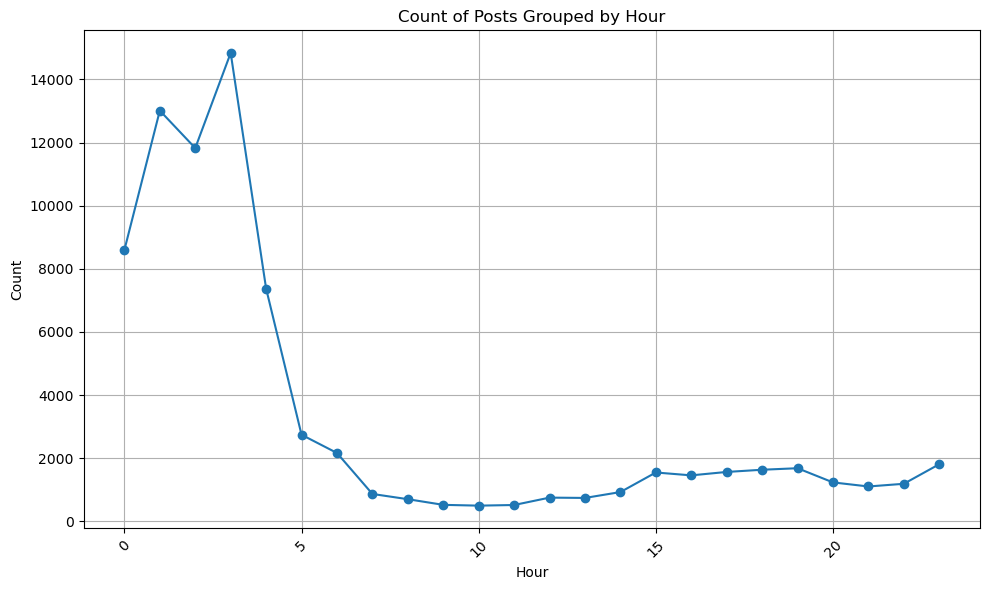

In [28]:
grouped_by_hour = reddit_t20_df.groupby(reddit_t20_df['Time'].dt.hour).size()

plt.figure(figsize=(10, 6))
grouped_by_hour.plot(kind='line', marker='o')  
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Count of Posts Grouped by Hour')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

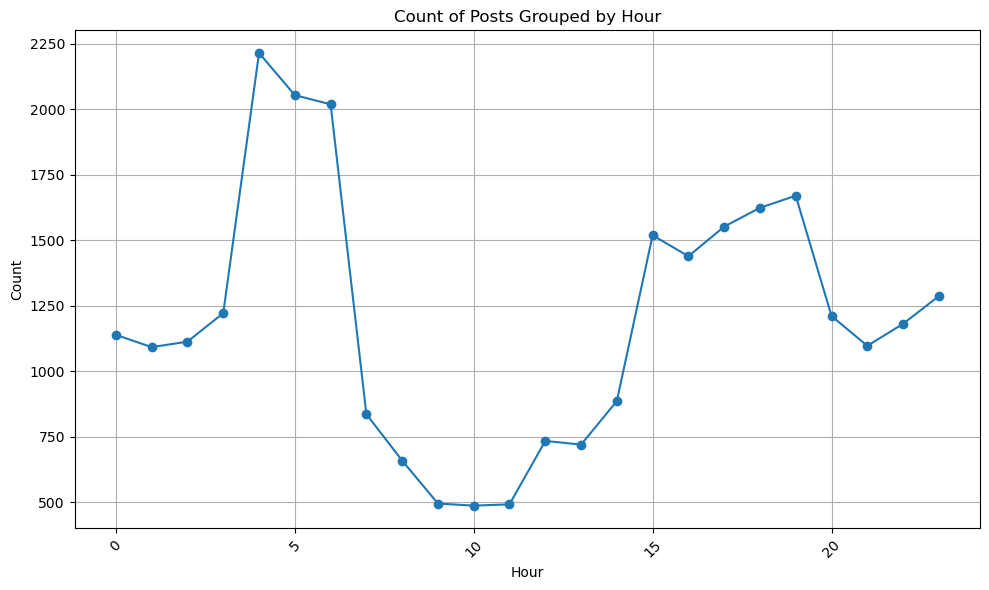

In [29]:
grouped_by_hour = filtered_posts.groupby(filtered_posts['Time'].dt.hour).size()

plt.figure(figsize=(10, 6))
grouped_by_hour.plot(kind='line', marker='o')  
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Count of Posts Grouped by Hour')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# to plot score vs no_comments without filtering data
posts = reddit_t20_df[reddit_t20_df['Type']=='Post']
posts.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post
1223,1dny3w0,1dny3w0,2024-06-25 15:07:29,ICumCoffee,4691,703,Afghanistan makes history and qualify for the Semi-Final of 2024 T20 World Cup; their first ever. They will face South Africa in the 1st Semi-Final,Post
1927,1dny8mp,1dny8mp,2024-06-25 15:16:00,ll--o--ll,2215,653,"WTC 2023 and ODI WC 2023 Champions, Australia, are out of the T20 WC 2024 and are heading back home",Post
2581,1di2lnd,1di2lnd,2024-06-18 02:40:56,harshmangat,3699,281,Lockie Ferguson bowls the most economical spell in T20 history with 4 maidens.,Post
2863,1bp8a53,1bp8a53,2024-03-28 04:55:47,pluto_N,4048,229,"Records made in today's IPL match, The craziest T20 match in history",Post


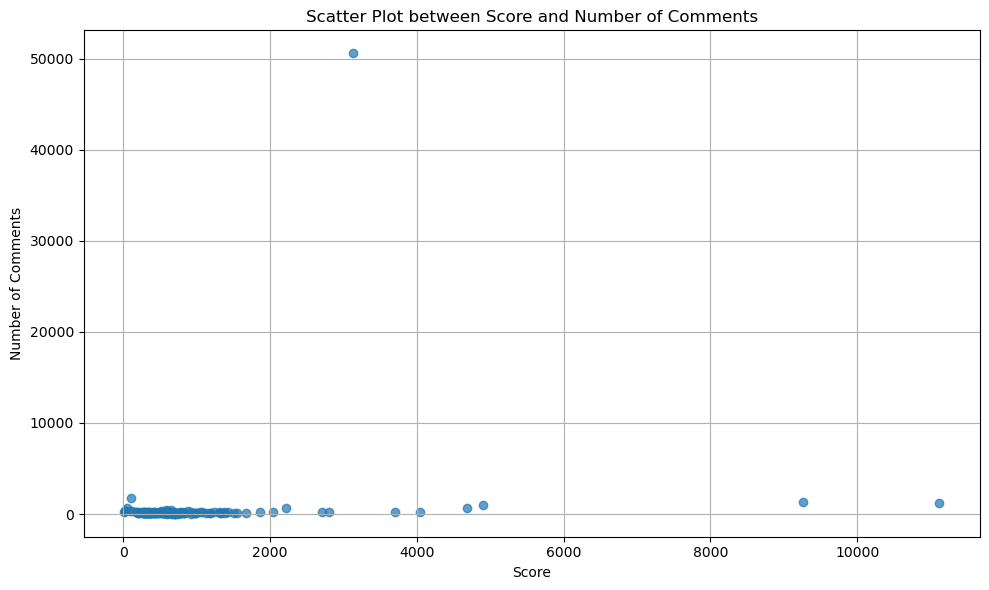

In [31]:
# score vs no_of comments
plt.figure(figsize=(10, 6))
plt.scatter(posts['Score'], posts['No_comments'], alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.title('Scatter Plot between Score and Number of Comments')
plt.grid(True)
plt.tight_layout()
plt.show()

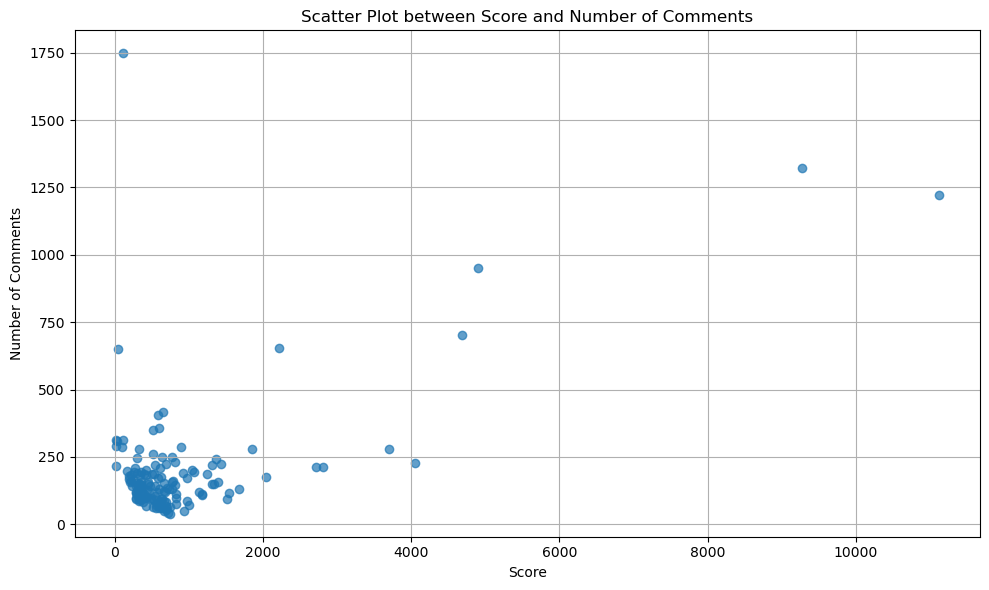

In [32]:
# to plot score vs no_comments ignoring T20 final post
posts = filtered_posts[filtered_posts['Type']=='Post']

# score vs no_of comments
plt.figure(figsize=(10, 6))
plt.scatter(posts['Score'], posts['No_comments'], alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.title('Scatter Plot between Score and Number of Comments')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
filtered_posts[filtered_posts['No_comments']>1500]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
13673,19b2mf4,19b2mf4,2024-01-20 14:50:14,lancewithwings,113,1748,Match Thread - T20 Black Clash (Team Rugby v Team Cricket) at Bay Oval,Post


In [34]:
filtered_posts[filtered_posts['Post_id']=='19b2mf4']

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
13673,19b2mf4,19b2mf4,2024-01-20 14:50:14,lancewithwings,113,1748,Match Thread - T20 Black Clash (Team Rugby v Team Cricket) at Bay Oval,Post
13674,19b2mf4,kipokwp,2024-01-20 18:56:17,the_maddest_kiwi,55,0,That was crack up but also one of the many reasons why it's fucked up that the TAB actually let anyone bet on this game,Comment
13675,19b2mf4,kipmvon,2024-01-20 18:36:11,__JimmyC__,46,0,Time for our yearly reminder that Vettori is still the best spinner in the country,Comment
13676,19b2mf4,kip0tjb,2024-01-20 15:03:28,crashbandicoochy,45,0,I can't believe I'm getting to see a legend of the game play against after so many years.\n\nI've missed Colin Slade so much.,Comment
13677,19b2mf4,kipd4c7,2024-01-20 16:50:14,theilluminary,41,0,"""You can send your complaints straight to us, not through the Broadcasting Standards Authority."" LMFAOOO",Comment
...,...,...,...,...,...,...,...,...
15417,19b2mf4,kiq1eda,2024-01-20 21:36:39,AndydaAlpaca,2,0,That's an awful joke...\n\nEwe can do better,Comment
15418,19b2mf4,kiplx60,2024-01-20 18:24:57,AndydaAlpaca,3,0,Mounted by it?,Comment
15419,19b2mf4,kiphzq1,2024-01-20 17:40:23,crashbandicoochy,1,0,That's a much better combo honestly. Has mu h better and more masculine reputation.\n\nGem cancers are toxic and sensitive little gremlins.,Comment
15420,19b2mf4,kiplz0q,2024-01-20 18:25:34,crashbandicoochy,3,0,I suppose what I was trying to say is that its turned me into a Ken doll.,Comment


In [35]:
# posts with more than 4000 score
filtered_posts[filtered_posts['Score']>4000]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post
1223,1dny3w0,1dny3w0,2024-06-25 15:07:29,ICumCoffee,4691,703,Afghanistan makes history and qualify for the Semi-Final of 2024 T20 World Cup; their first ever. They will face South Africa in the 1st Semi-Final,Post
2863,1bp8a53,1bp8a53,2024-03-28 04:55:47,pluto_N,4048,229,"Records made in today's IPL match, The craziest T20 match in history",Post
20029,1d9r965,1d9r965,2024-06-07 05:51:01,CarnivalSorts,9267,1324,USA make history and beat Pakistan in a Super Over in Dallas,Post
77113,1dc27f7,1dc27f7,2024-06-10 05:40:14,pluto_N,4905,951,India defeat Pakistan by 6 runs in New York,Post


In [36]:
# post and comment length
post_length = []

for body in reddit_t20_df['Body']:
    post_length.append(len(body))

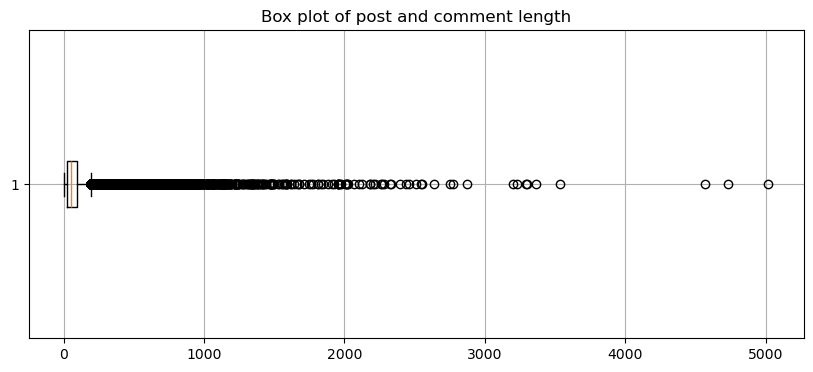

In [37]:
# visalizing post/comment length distribution
plt.figure(figsize=(10, 4))
plt.boxplot(post_length, vert=False)
plt.grid(True)
plt.title('Box plot of post and comment length')
plt.show()

In [38]:
# median value for post and comment length
median_value = statistics.median(post_length)

print(f"The median post/comment length: {median_value}")

The median post/comment length: 49


In [39]:
high_length=reddit_t20_df[reddit_t20_df['Body'].str.len() > 3000]
high_length

Post_id       Id                Time               Author  Score  \
11029  1cjpwld  l2idmni 2024-05-04 16:52:12  Ok_Environment_5404     19   
11045  1cjpwld  l2ioqcs 2024-05-04 19:09:26          lastballsix     -6   
15826  1c78p1f  l0a9k3e 2024-04-19 21:48:25  Ok_Environment_5404      2   
15861  1c78p1f  l0fe1mz 2024-04-20 19:47:03  Ok_Environment_5404      1   
21930  1dtg5b7  lb94oeb 2024-07-02 17:40:26            ll--o--ll     49   
24507  1dtohrm  lbdmdbl 2024-07-03 11:32:25               depooh     20   
75535  1cfvhgv  l1tozco 2024-04-30 04:38:52  Ok_Environment_5404      5   
78250  1bie008  kvs25h1 2024-03-21 06:28:32     Mikolaj_Kopernik      2   
78254  1bie008  kvtu35j 2024-03-21 12:47:10     Mikolaj_Kopernik      1   

       No_comments  \
11029            0   
11045            0   
15826            0   
15861            0   
21930            0   
24507            0   
75535            0   
78250            0   
78254            0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [40]:
high_length_posts = high_length['Post_id']
high_length_posts

11029    1cjpwld
11045    1cjpwld
15826    1c78p1f
15861    1c78p1f
21930    1dtg5b7
24507    1dtohrm
75535    1cfvhgv
78250    1bie008
78254    1bie008
Name: Post_id, dtype: object

In [41]:
reddit_t20_df[(reddit_t20_df['Post_id'].isin(high_length_posts)) & (reddit_t20_df['Type'] == 'Post')]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
10853,1cjpwld,1cjpwld,2024-05-04 12:34:30,ilakatamafilia,545,220,Most runs scored by a batsmen in t20 worldcup history,Post
15685,1c78p1f,1c78p1f,2024-04-19 03:10:08,kundu123,429,200,Virat Kohli’s middle-overs slowdown makes him viable only for the opening slot at T20 World Cup,Post
21926,1dtg5b7,1dtg5b7,2024-07-02 17:39:41,ll--o--ll,358,118,Mitchell Johnson: Jake Fraser-McGurk was worth the punt for Australia in failed T20 World Cup campaign,Post
24437,1dtohrm,1dtohrm,2024-07-03 01:23:46,Yeahanu,325,87,"Pakistan team 'deserves' criticism, says Rizwan after T20 World Cup debacle",Post
75390,1cfvhgv,1cfvhgv,2024-04-29 20:13:23,TopAd9295,220,181,India's T20 World Cup squad: IPL form unlikely to heavily influence selection,Post
78065,1bie008,1bie008,2024-03-19 17:48:28,MaleficentOne4798,170,197,CA postpones Afghan T20 series,Post


In [42]:
# no of unique authors
num_unique_authors = reddit_t20_df['Author'].nunique()
num_unique_authors

11680

In [43]:
# no of unique authors excluding T20 final post
num_unique_authors = filtered_posts['Author'].nunique()
num_unique_authors

7672

In [44]:
# no of unqiue authors in T20 final post
reddit_t20_df[reddit_t20_df['Post_id']=='1drb4pt']['Author'].nunique()

5979

In [45]:
# possible bots as authors
contains_bot = reddit_t20_df['Author'].str.lower().str.contains('bot')
authors_with_bot = reddit_t20_df[contains_bot]
possible_bots = authors_with_bot['Author'].unique()
possible_bots

array(['BreadfruitBoth165', 'Both_Echo_3581', 'Necessary-Bother7448',
       'botharmsinjured', 'robot_pyjamas', 'blue-klein-bottle',
       'llobotommy', 'notautobot', 'RobotMugabe', 'ChattyBot7',
       'navelBot1', 'Both_Tennis_6033', 'McFoodBot', 'thememesbot',
       'SnooRobots6923', 'therobot20', 'Booty_Warrior_bot', 'JigglingBot',
       'capybara_bot', 'KatnissBot', 'Both-Session-6668',
       'AverageBottasEnjoyer', 'Pak_Info_Bot', 'Wigglebot23',
       'housebottle', 'CricketMatchBot', 'toxicityratingbot',
       'M_not_robot', 'SnooRobots3480', 'bot_fucker69',
       'PRBOTISMYCOUNTRY', 'BothersomeKoala', 'notabot_123'], dtype=object)

In [46]:
bots = ['ChattyBot7','Booty_Warrior_bot','JigglingBot','capybara_bot','KatnissBot','Wigglebot23',
        'CricketMatchBot','Pak_Info_Bot','toxicityratingbot','SnooRobots6923','therobot20','notabot_123',
        'notautobot','McFoodBot','navelBot1','thememesbot']

In [47]:
# remove posts/comments by bots
bot_filter = (reddit_t20_df['Author'].isin(bots)) & (reddit_t20_df['Type'] == 'Comment')
reddit_t20_df = reddit_t20_df[~bot_filter]

In [48]:
reddit_t20_df.shape

(79224, 8)

In [49]:
# no of unique authors
num_unique_authors = reddit_t20_df['Author'].nunique()
num_unique_authors

11666

In [50]:
# no of unqiue authors in T20 final post
reddit_t20_df[reddit_t20_df['Post_id']=='1drb4pt']['Author'].nunique()

5977

In [51]:
# no of unique authors excluding T20 final post
reddit_t20_df[reddit_t20_df['Post_id']!='1drb4pt']['Author'].nunique()

7660

In [52]:
# top authors
comment_count_by_author = reddit_t20_df.groupby('Author').size().reset_index(name='Comment/Post_Count')
comment_count_by_author = comment_count_by_author.sort_values(by='Comment/Post_Count', ascending=False)
comment_count_by_author.head(n=50)

,Author,Comment/Post_Count
7940,deleted,5031
1403,Cricket-ModTeam,452
6091,Tern_Larvidae-2424,274
6084,Temporary-Shallot642,245
7782,crashbandicoochy,227
6466,Unusual-Surround7467,222
6588,VisRock,217
2811,Idlisamosadosa,178
9353,mashbe,175
4688,PlapPlapProass,171


In [53]:
reddit_t20_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post
1,1drh232,lav528s,2024-06-30 04:04:36,AssociationNo9219,2969,0,The death over bowling from India when 30 of 30 was needed is the type of nerves we needed under pressure,Comment
2,1drh232,lav4wrb,2024-06-30 04:03:41,sherlockwm,1324,0,South Africa had just sniffed the cup and India took it away,Comment
3,1drh232,lav55k3,2024-06-30 04:05:11,ghazilazi,1736,0,"I have no idea how India managed to come back from 30(30), but Jasprit Bumrah is a cheat code.",Comment
4,1drh232,lav5kim,2024-06-30 04:07:49,Rytnix07,550,0,"The cruelty of sport. The two teams which came to the final were in drought for an ICC trophy. As an Indian I am overjoyed, and congrats to SA for such an amazing battle. \n\nSeeing Miller cry broke my heart, Stand proud SA you played so well.",Comment


In [54]:
# defining a function to tokenize data
def data_tokenizer(text, tokenizer):

    token_list = tokenizer.tokenize(text)
    token_list = [token.strip() for token in token_list]

    return token_list

In [55]:
# initializing the necessary components
tokenizer = nltk.tokenize.TweetTokenizer()
punctuations = list(string.punctuation)
lStopwords = nltk.corpus.stopwords.words('english') + punctuations + ['...','']
stemmer = nltk.stem.PorterStemmer()
lemmatizer = WordNetLemmatizer()
vader_analyzer = SentimentIntensityAnalyzer()

In [56]:
# defining the dictionary for pos tag mapping
pos_map = {'ADJ':'a','ADP':'s','ADV':'r','NOUN':'n','VERB':'v'}

In [57]:
# generating tokens

# to store tokens
tokens =[]

# defining a counter to count the tokens
termFreqCounter = Counter()

for body in reddit_t20_df['Body']:
    temp_tokens = data_tokenizer(body,tokenizer)
    tokens.append(temp_tokens)
    termFreqCounter.update(temp_tokens)

In [58]:
# checking tokens list
tokens[1]

['The',
 'death',
 'over',
 'bowling',
 'from',
 'India',
 'when',
 '30',
 'of',
 '30',
 'was',
 'needed',
 'is',
 'the',
 'type',
 'of',
 'nerves',
 'we',
 'needed',
 'under',
 'pressure']

In [59]:
# observing token counts for 50 most common tokens
for term, count in termFreqCounter.most_common(50):
    print(term + ': ' + str(count))

.: 57157
the: 42122
,: 29165
to: 25098
a: 23627
in: 21221
and: 20323
is: 18605
of: 15642
I: 12902
for: 12675
it: 10871
that: 10866
?: 9860
this: 9488
was: 8613
’: 8096
have: 7862
you: 7561
be: 7520
!: 7408
he: 6914
on: 6890
not: 6657
are: 6522
they: 5876
but: 5734
with: 5606
India: 5309
we: 5165
Kohli: 4805
at: 4780
as: 4673
like: 4581
): 4547
will: 4484
(: 4474
from: 4386
has: 4316
just: 4256
so: 3973
out: 3967
over: 3944
his: 3880
team: 3872
s: 3801
all: 3779
if: 3772
can: 3676
or: 3556


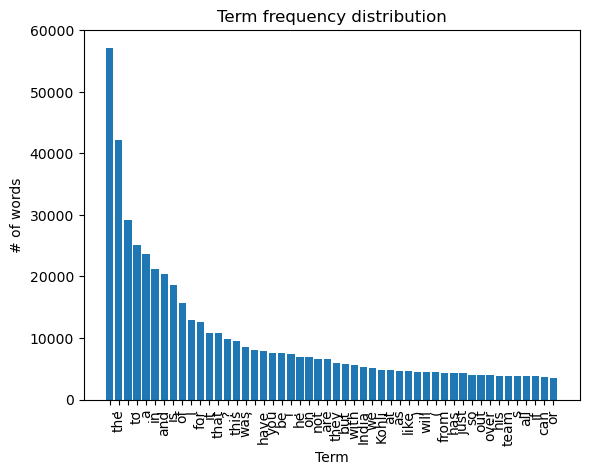

In [60]:
# plotting most common term counts
y = [count for tag, count in termFreqCounter.most_common(50)]
x = [tag for tag, count in termFreqCounter.most_common(50)]

plt.bar(x, y)
plt.title("Term frequency distribution")
plt.ylabel('# of words')
plt.xlabel('Term')
plt.xticks(rotation = 90)
plt.show()

In [61]:
# defining a function for pre-processing

def preprocessor_lemmatizer(text):
    # remove unicode character
    text = re.sub(u"(\u2018|\u2019|\u2014|\u2026|\u201d|\u201c|\ud83e|\udd14|U+002E|U+002E|=/|\.{2,})", "",text)
    # tokenization
    token_list = tokenizer.tokenize(text)
    # strip white spaces
    token_list = [token.strip() for token in token_list]
    # converting to lowercase
    token_list = [token.lower() for token in token_list]

    # to identify numbers (both decimal and real numbers)
    digit_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    # to identify links
    link_pattern = re.compile(r'^http.*|.*\.com|^www.*')
    # to identify tokens with mixed letters and digits
    digit_letter_mix_pattern = re.compile(r"^(?=.*[A-Za-z])(?=.*\d)[A-Za-z\d]+$")

    token_list = [token for token in token_list if token not in lStopwords and digit_pattern.match(token) == None and link_pattern.match(token) == None and digit_letter_mix_pattern.match(token) == None and token.strip()]

    # identify pos tags
    tags = pos_tag(token_list, tagset='universal')

    # mapping to a readble pos tag format for lemmatizer
    tags = [(token,pos_map[tag] if tag in pos_map.keys() else 'n')for (token,tag) in tags]

    # lemmatizations
    token_list = [lemmatizer.lemmatize(token,tag) for (token,tag) in tags]
    
    # remove single letter tokens
    token_list = [token for token in token_list if len(token)>1]

    return token_list

<>:5: DeprecationWarning: invalid escape sequence '\.'
<>:5: DeprecationWarning: invalid escape sequence '\.'
C:\Users\sppag\AppData\Local\Temp\ipykernel_34904\1105828012.py:5: DeprecationWarning: invalid escape sequence '\.'
  text = re.sub(u"(\u2018|\u2019|\u2014|\u2026|\u201d|\u201c|\ud83e|\udd14|U+002E|U+002E|=/|\.{2,})", "",text)


In [62]:
# applying pre-processing

# defining a counter to count the frequency of tokens
termFreqCounter = Counter()

preprocessed_tokens = []

for body in tqdm(reddit_t20_df['Body']):
    temp_tokens = preprocessor_lemmatizer(body)
    preprocessed_tokens.append(temp_tokens)
    termFreqCounter.update(temp_tokens)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

In [63]:
# observing token counts for 50 most common tokens
for term, count in termFreqCounter.most_common(200):
    print(term + ': ' + str(count))

get: 7118
india: 6028
kohli: 5863
play: 5628
team: 5357
like: 4936
go: 4588
good: 4398
one: 4128
game: 4072
cricket: 3836
win: 3783
match: 3771
well: 3726
need: 3610
would: 3297
time: 3227
even: 3181
final: 3094
sa: 3088
ball: 3081
think: 2991
make: 2929
run: 2904
bumrah: 2826
world: 2748
player: 2747
wicket: 2693
say: 2635
cup: 2578
fuck: 2480
take: 2472
see: 2467
score: 2419
rohit: 2364
lose: 2349
wc: 2309
come: 2276
look: 2213
last: 2150
still: 2137
bowl: 2116
bat: 2065
give: 2056
pitch: 2047
dube: 2026
man: 2020
over: 1983
axar: 1937
know: 1926
year: 1867
inning: 1865
hit: 1822
also: 1759
really: 1729
lol: 1715
much: 1660
best: 1656
indian: 1650
guy: 1632
people: 1608
today: 1604
bowler: 1596
hardik: 1591
tournament: 1586
way: 1571
bad: 1571
back: 1567
watch: 1539
want: 1525
fan: 1525
great: 1518
south: 1496
ipl: 1494
choke: 1485
first: 1476
big: 1474
shit: 1397
please: 1350
start: 1312
never: 1269
could: 1244
day: 1244
test: 1233
pakistan: 1229
comment: 1229
africa: 1215
end: 1202

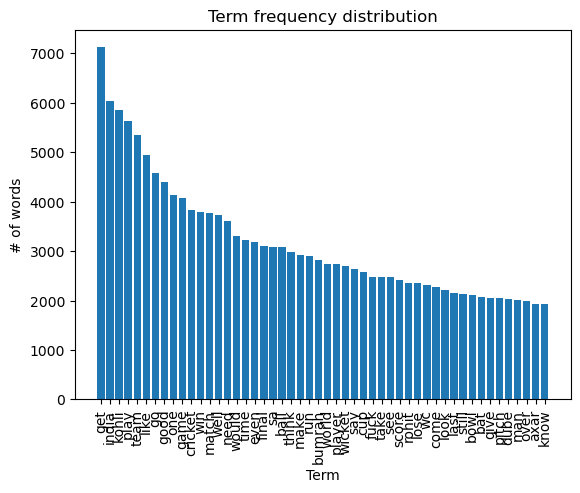

In [64]:
# plotting most common term counts
y = [count for tag, count in termFreqCounter.most_common(50)]
x = [tag for tag, count in termFreqCounter.most_common(50)]

plt.bar(x, y)
plt.title("Term frequency distribution")
plt.ylabel('# of words')
plt.xlabel('Term')
plt.xticks(rotation = 90)
plt.show()

In [65]:
preprocessed_tokens[2]

['south', 'africa', 'sniff', 'cup', 'india', 'take', 'away']

In [66]:
joinned_tokens = [" ".join(tokens) for tokens in preprocessed_tokens]

In [67]:
reddit_t20_df.loc[:, 'Processed_1'] = joinned_tokens

In [68]:
reddit_t20_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post,india champion world cup
1,1drh232,lav528s,2024-06-30 04:04:36,AssociationNo9219,2969,0,The death over bowling from India when 30 of 30 was needed is the type of nerves we needed under pressure,Comment,death bowling india need type nerve need pressure
2,1drh232,lav4wrb,2024-06-30 04:03:41,sherlockwm,1324,0,South Africa had just sniffed the cup and India took it away,Comment,south africa sniff cup india take away
3,1drh232,lav55k3,2024-06-30 04:05:11,ghazilazi,1736,0,"I have no idea how India managed to come back from 30(30), but Jasprit Bumrah is a cheat code.",Comment,idea india manage come back jasprit bumrah cheat code
4,1drh232,lav5kim,2024-06-30 04:07:49,Rytnix07,550,0,"The cruelty of sport. The two teams which came to the final were in drought for an ICC trophy. As an Indian I am overjoyed, and congrats to SA for such an amazing battle. \n\nSeeing Miller cry broke my heart, Stand proud SA you played so well.",Comment,cruelty sport two team come final drought icc trophy indian overjoy congrats sa amazing battle see miller cry break heart stand proud sa play well


In [69]:
# defining a pre-processor for vader
def vader_pre_processor(text):
    tokens = tokenizer.tokenize(text)

    # removing digits
    digit_pattern = re.compile(r"\b\d+(\.\d+)?\b")
    # removing links
    link_pattern = re.compile(r'^http.*|.*\.com|^www.*')

    # filtering tokens
    tokens = [token.strip() for token in tokens if digit_pattern.match(token)==None and link_pattern.match(token)==None and token.strip()]

    # joining tokens togeter
    text = ' '.join(tokens)

    return text

In [70]:
#apply vader preprocessing
vader_tokens = []

for body in tqdm(reddit_t20_df['Body']):
    temp_tokens = vader_pre_processor(body)
    vader_tokens.append(temp_tokens)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

In [76]:
reddit_t20_df.loc[:, 'Processed_2'] = vader_tokens

In [77]:
reddit_t20_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
0,1drh232,1drh232,2024-06-30 04:02:03,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post,india champion world cup,India are the champions of T20 World Cup
1,1drh232,lav528s,2024-06-30 04:04:36,AssociationNo9219,2969,0,The death over bowling from India when 30 of 30 was needed is the type of nerves we needed under pressure,Comment,death bowling india need type nerve need pressure,The death over bowling from India when of was needed is the type of nerves we needed under pressure
2,1drh232,lav4wrb,2024-06-30 04:03:41,sherlockwm,1324,0,South Africa had just sniffed the cup and India took it away,Comment,south africa sniff cup india take away,South Africa had just sniffed the cup and India took it away
3,1drh232,lav55k3,2024-06-30 04:05:11,ghazilazi,1736,0,"I have no idea how India managed to come back from 30(30), but Jasprit Bumrah is a cheat code.",Comment,idea india manage come back jasprit bumrah cheat code,"I have no idea how India managed to come back from ( ) , but Jasprit Bumrah is a cheat code ."
4,1drh232,lav5kim,2024-06-30 04:07:49,Rytnix07,550,0,"The cruelty of sport. The two teams which came to the final were in drought for an ICC trophy. As an Indian I am overjoyed, and congrats to SA for such an amazing battle. \n\nSeeing Miller cry broke my heart, Stand proud SA you played so well.",Comment,cruelty sport two team come final drought icc trophy indian overjoy congrats sa amazing battle see miller cry break heart stand proud sa play well,"The cruelty of sport . The two teams which came to the final were in drought for an ICC trophy . As an Indian I am overjoyed , and congrats to SA for such an amazing battle . Seeing Miller cry broke my heart , Stand proud SA you played so well ."


In [ ]:
# sentiment analysis

In [78]:
# computing sentimenet for each comment/post
vader_sentiments = []

for index,row in tqdm(reddit_t20_df.iterrows(),total=79224):
    
    #apply pre-processing
    text = row['Processed_2']
    
    #vader polarity score
    vader_score = vader_analyzer.polarity_scores(text)
    
    #time for the comment
    comment_date = row['Time']
    
    vader_sentiments.append([comment_date, vader_score['compound']])
    

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

In [79]:
vader_sentiments[:5]

[[Timestamp('2024-06-30 04:02:03'), 0.5267],
 [Timestamp('2024-06-30 04:04:36'), -0.7579],
 [Timestamp('2024-06-30 04:03:41'), 0.0],
 [Timestamp('2024-06-30 04:05:11'), -0.6808],
 [Timestamp('2024-06-30 04:07:49'), 0.7745]]

In [80]:
# converting to dataframe
t20_sentiment = pd.DataFrame(vader_sentiments,columns=["Date_time","Sentiment"])
t20_sentiment['Date_time']=pd.to_datetime(t20_sentiment['Date_time'])
t20_sentiment['Date_time']=t20_sentiment['Date_time'].dt.date

#aggregating
t20_sentiment_aggregated = t20_sentiment.groupby('Date_time')['Sentiment'].mean().reset_index()

In [81]:
t20_sentiment_aggregated.head()

,Date_time,Sentiment
0,2023-12-01,0.078370
1,2023-12-02,0.094182
2,2023-12-06,0.148189
3,2023-12-07,0.149796
4,2023-12-08,0.129560


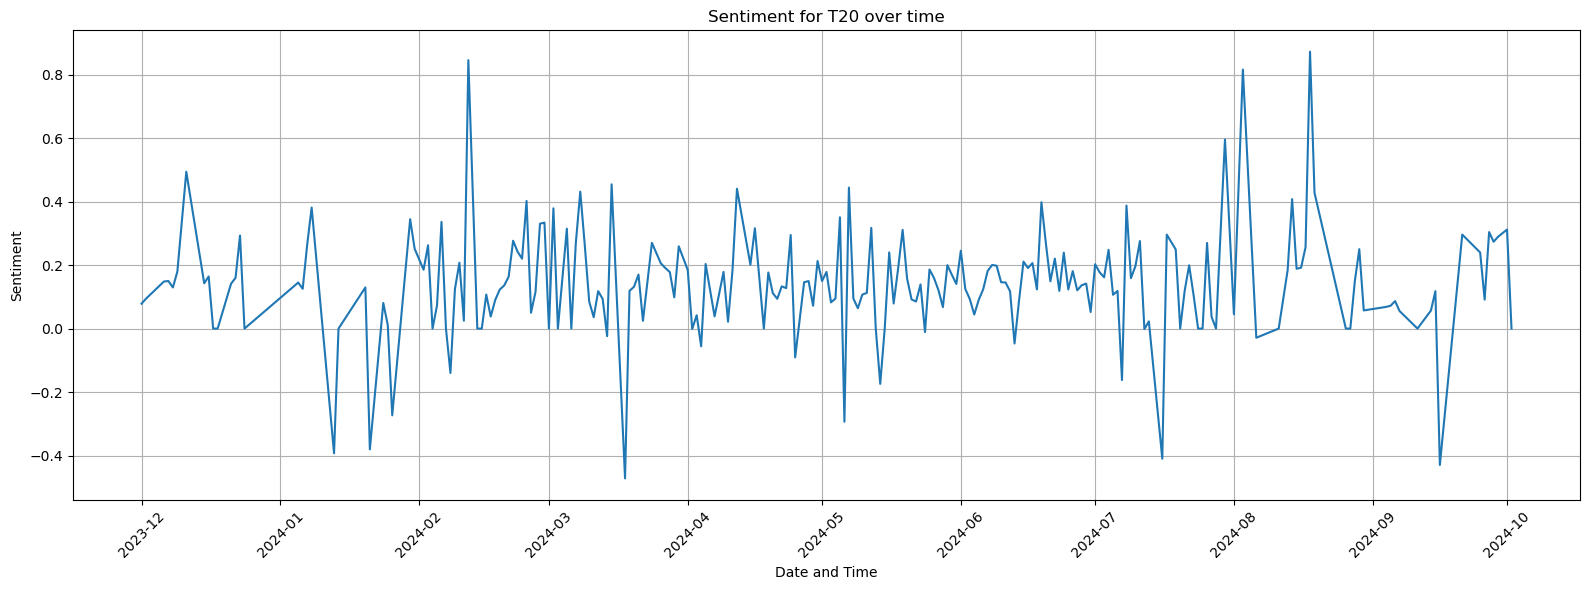

In [82]:
# plotting sentiment
plt.figure(figsize=(16, 6))
plt.plot(t20_sentiment_aggregated['Date_time'],t20_sentiment_aggregated['Sentiment'],linestyle='-')
plt.title('Sentiment for T20 over time')
plt.xlabel('Date and Time')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# sentiment is mostly towards positive

In [ ]:
# exploring sentiments above 0.5

In [83]:
t20_sentiment_aggregated[t20_sentiment_aggregated['Sentiment']>0.5]

,Date_time,Sentiment
39,2024-02-12,0.84520
193,2024-07-30,0.59535
195,2024-08-03,0.81560
203,2024-08-18,0.87200


In [84]:
date_filter = ((reddit_t20_df['Time'].dt.date == datetime(2024, 2, 12).date()) | 
               (reddit_t20_df['Time'].dt.date == datetime(2024, 7, 30).date()) |
               (reddit_t20_df['Time'].dt.date == datetime(2024, 8, 3).date()) | 
               (reddit_t20_df['Time'].dt.date == datetime(2024, 8, 18).date()))

In [85]:
high_sentiment=reddit_t20_df[date_filter]
high_sentiment

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
4268,1ec9slq,lfkzoav,2024-07-30 11:29:12,bruceparker4321,1,0,"Thats one of the other reason I like test cricket, its eveb ppssible that a match may tie/draw after 5 days, so it teaches that even after you try for som thing for days on end, there are chances you mught still not achieve it",Comment,thats one reason like test cricket eveb ppssible match may tie draw day teach even try som thing day end chance mught still achieve,"Thats one of the other reason I like test cricket , its eveb ppssible that a match may tie / draw after days , so it teaches that even after you try for som thing for days on end , there are chances you mught still not achieve it"
4270,1ec9slq,lfkzyl4,2024-07-30 11:31:02,bruceparker4321,2,0,"Rightly said, test cricket apart from being the most entertaining of all formats, it also teaches a lot of things like patience, stamina, perseverance and even that you may not achieve the thing for which you fought for days on end",Comment,rightly say test cricket apart entertain format also teach lot thing like patience stamen perseverance even may achieve thing fought day end,"Rightly said , test cricket apart from being the most entertaining of all formats , it also teaches a lot of things like patience , stamina , perseverance and even that you may not achieve the thing for which you fought for days on end"
4306,1ec9slq,lg9oufn,2024-08-03 17:44:44,Frankerian,1,0,"Thanks for that - I would love to have a specific reference; presumably a first class match, not a test match? Do you have a specific reference for me?",Comment,thanks would love specific reference presumably first class match test match specific reference,"Thanks for that - I would love to have a specific reference ; presumably a first class match , not a test match ? Do you have a specific reference for me ?"
10602,1esj96y,likqz6j,2024-08-18 01:24:09,Interesting_Type_824,1,0,"3rd in SA mate, never gonna beat Rugby, with neither sport ever matching the popularity of Football. Hint: Football's popularity not dependent on national team success, hence why No1 in the world.",Comment,sa mate never gonna beat rugby neither sport ever match popularity football hint football's popularity dependent national team success hence world,"3rd in SA mate , never gonna beat Rugby , with neither sport ever matching the popularity of Football . Hint : Football's popularity not dependent on national team success , hence why No1 in the world ."
19587,1amegb7,kq1uysw,2024-02-12 17:39:40,WakeUpMareeple,1,0,"My eyeballs watching speed guns.\n\nPersonally, I think it's a result of biomechanics and the like. The old method was essentially to let bowlers largely do whatever they wanted, and the ones whose bodies could handle it would succeed, and the ones whose bodies couldn't would just have to live with constantly breaking down (like Ian Bishop) unless they took the time to completely change their method, like Lillee, who slowed down considerably but elongated his career.\n\nModern sports science catches these actions early, but the flipside is that we don't see bowlers hitting 150 as much as we used to. The fact that Shamar Joseph did so after coming out of obscurity (untouched by sports scientists) is probably not a coincidence. This isn't necessarily a bad thing, but it gives lie to the idea that time = faster bowlers.",Comment,eyeball watch speed gun personally think result biomechanics like old method essentially let bowler largely whatever wanted one whose body could handle would succeed one whose body would live constantly break like ian bishop unless take time completely change method like lillee slow considerably elongate career modern sport science catch action early flipside see bowler hit much use fact shamar joseph come obscurity untouched sport scientist probably coincidence necessarily bad thing give lie idea time faster bowler,"My eyeballs watching speed guns . Personally , I think it's

In [86]:
# calculate sentiment for comments selected days
t_vader_sentiments = []

for index,row in tqdm(high_sentiment.iterrows(),total=5):
    
    #apply pre-processing
    text = vader_pre_processor(row['Body'])
    
    #vader polarity score
    vader_score = vader_analyzer.polarity_scores(text)
    
    #time for the comment
    comment_date = row['Time']
    
    t_vader_sentiments.append([comment_date, vader_score['compound']])

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/5 [00:00<?, ?it/s]

In [87]:
t_vader_sentiments

[[Timestamp('2024-07-30 11:29:12'), 0.5106],
 [Timestamp('2024-07-30 11:31:02'), 0.6801],
 [Timestamp('2024-08-03 17:44:44'), 0.8156],
 [Timestamp('2024-08-18 01:24:09'), 0.872],
 [Timestamp('2024-02-12 17:39:40'), 0.8452]]

In [88]:
post_ids = high_sentiment['Post_id'].unique()
post_ids

array(['1ec9slq', '1esj96y', '1amegb7'], dtype=object)

In [89]:
reddit_t20_df[(reddit_t20_df['Post_id'].isin(post_ids)) & (reddit_t20_df['Type']=='Post')]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
4195,1ec9slq,1ec9slq,2024-07-26 09:50:12,98nissansentra,1243,188,New cricket fan: What's going on here? I've noticed that less crazy versions of this set up happen in Test but I've not seen it in T20.,Post,new cricket fan what's go i've notice less crazy version set happen test i've see,New cricket fan : What's going on here ? I've noticed that less crazy versions of this set up happen in Test but I've not seen it in T20 .
10511,1esj96y,1esj96y,2024-08-15 11:55:00,RMTBolton,298,245,"Conway, Allen opt out of NZ Cricket contracts to pursue T20 franchise opportunities",Post,conway allen opt nz cricket contract pursue franchise opportunity,"Conway , Allen opt out of NZ Cricket contracts to pursue T20 franchise opportunities"
19408,1amegb7,1amegb7,2024-02-09 14:23:09,MORETHANAPROF1,418,183,"I was watching highlights of a T20 match between Australia and England in 2011 and Australia had Tait, Lee and Johnson bowling! Has there ever been a faster trio bowling in a match together?",Post,watch highlight match australia england australia tait lee johnson bowl ever faster trio bowl match together,"I was watching highlights of a T20 match between Australia and England in and Australia had Tait , Lee and Johnson bowling ! Has there ever been a faster trio bowling in a match together ?"


In [90]:
# exploring sentiments above -0.3

In [91]:
t20_sentiment_aggregated[t20_sentiment_aggregated['Sentiment']<-0.3]

,Date_time,Sentiment
20,2024-01-13,-0.39265
23,2024-01-21,-0.38040
70,2024-03-18,-0.47170
181,2024-07-16,-0.40975
217,2024-09-16,-0.42950


In [92]:
date_filter_l = ((reddit_t20_df['Time'].dt.date == datetime(2024, 1, 13).date()) | 
               (reddit_t20_df['Time'].dt.date == datetime(2024, 1, 21).date()) |
               (reddit_t20_df['Time'].dt.date == datetime(2024, 3, 18).date()) | 
               (reddit_t20_df['Time'].dt.date == datetime(2024, 7, 16).date()) |
               (reddit_t20_df['Time'].dt.date == datetime(2024, 9, 16).date()))

In [93]:
low_sentiment=reddit_t20_df[date_filter_l]
low_sentiment

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
5257,1drjhny,ldf8zb0,2024-07-16 18:47:55,FollowingHim,1,0,I don't know man... Doesn't feel right. It's almost like SA did not want to take a run a ball. SA club players could have done just that. \n \nWhich makes me think... Maybe someone told them that they will loose their IPL contracts??? \n \nIf so... I think cricket SA should just fire them and replace team members with IPL contracts.,Comment,know man feel right almost like sa want take run ball sa club player could do make think maybe someone tell loose ipl contract think cricket sa fire replace team member ipl contract,I don't know man ... Doesn't feel right . It's almost like SA did not want to take a run a ball . SA club players could have done just that . Which makes me think ... Maybe someone told them that they will loose their IPL contracts ? ? ? If so ... I think cricket SA should just fire them and replace team members with IPL contracts .
5513,1bah74d,kvew9ww,2024-03-18 22:44:36,Alternative_Credit64,1,0,Thought you said Bangladesh can't win a series against Sri Lanka? They did just now.,Comment,think say bangladesh can't win series sri lanka,Thought you said Bangladesh can't win a series against Sri Lanka ? They did just now .
7272,1dsuhey,ldf51kl,2024-07-16 18:01:27,One-Cold-too-cold,1,0,Ah yes. I remember that world cup in India. Tickets were sold so late and marketing was so poor many people didn't even know it started.,Comment,ah yes remember world cup india ticket sell late marketing poor many people even know start,Ah yes . I remember that world cup in India . Tickets were sold so late and marketing was so poor many people didn't even know it started .
8384,1dnxnhi,lnbd5av,2024-09-16 07:37:48,Still_Interaction_75,1,0,"There is no politics or corruption in BCB. People need to stop this propaganda and start to reflect on reality. Reality is, Bangladeshi people are idiots. Simple ![gif](emote|free_emotes_pack|grin)",Comment,politics corruption bcb people need stop propaganda start reflect reality reality bangladeshi people idiots simple gif emote free_emotes_pack grin,"There is no politics or corruption in BCB . People need to stop this propaganda and start to reflect on reality . Reality is , Bangladeshi people are idiots . Simple ! [ gif ] ( emote | free_emotes_pack | grin )"
9428,18yoeqo,khnc7n3,2024-01-13 20:31:01,Alternative_Credit64,0,0,"No they won't, no one takes them seriously and hence lose against them in bilateral matches occasionally. They will get destroyed in the world cup as always.",Comment,one take seriously hence lose bilateral match occasionally get destroyed world cup always,"No they won't , no one takes them seriously and hence lose against them in bilateral matches occasionally . They will get destroyed in the world cup as always ."
9499,18yoeqo,khncc9a,2024-01-13 20:32:38,Alternative_Credit64,1,0,It has now,Comment,,It has now
14992,19b2mf4,kirftpi,2024-01-21 04:12:16,deleted,0,0,It was the most boring black clash I’ve seen. Slow bowling…and shithouse commentary…,Comment,bore black clash ive see slow bowlingand shithouse commentary,It was the most boring black clash I ’ ve seen . Slow bowling … and shithouse commentary …


In [94]:
# calculate sentiment for comments selected days
l_vader_sentiments = []

for index,row in tqdm(low_sentiment.iterrows(),total=5):
    
    #apply pre-processing
    text = vader_pre_processor(row['Body'])
    
    #vader polarity score
    vader_score = vader_analyzer.polarity_scores(text)
    
    #time for the comment
    comment_date = row['Time']
    
    l_vader_sentiments.append([comment_date, vader_score['compound']])

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/5 [00:00<?, ?it/s]

In [95]:
l_vader_sentiments

[[Timestamp('2024-07-16 18:47:55'), -0.5032],
 [Timestamp('2024-03-18 22:44:36'), -0.4717],
 [Timestamp('2024-07-16 18:01:27'), -0.3163],
 [Timestamp('2024-09-16 07:37:48'), -0.4295],
 [Timestamp('2024-01-13 20:31:01'), -0.7853],
 [Timestamp('2024-01-13 20:32:38'), 0.0],
 [Timestamp('2024-01-21 04:12:16'), -0.3804]]

In [96]:
l_post_ids = low_sentiment['Post_id'].unique()
l_post_ids

array(['1drjhny', '1bah74d', '1dsuhey', '1dnxnhi', '18yoeqo', '19b2mf4'],
      dtype=object)

In [97]:
reddit_t20_df[(reddit_t20_df['Post_id'].isin(l_post_ids)) & (reddit_t20_df['Type']=='Post')]

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
5200,1drjhny,1drjhny,2024-06-30 05:53:32,SuperFaiz21,1073,195,"A ""gut wrenching"" loss in the T20 World Cup final for South Africa after a spirited performance..",Post,gut wrench loss world cup final south africa spirit performance,"A "" gut wrenching "" loss in the T20 World Cup final for South Africa after a spirited performance .."
5396,1bah74d,1bah74d,2024-03-09 23:59:52,eouia0011,1430,223,"Sri Lanka brings out the ""timed-out"" celebration after winning the T20 series 2-1 against Bangladesh",Post,sri lanka bring timed-out celebration win series bangladesh,"Sri Lanka brings out the "" timed-out "" celebration after winning the T20 series against Bangladesh"
7075,1dsuhey,1dsuhey,2024-07-02 00:34:33,fruppity,637,251,Was 2024 T20 WC the proper World Cup carnival we all deserved?,Post,wc proper world cup carnival deserve,Was T20 WC the proper World Cup carnival we all deserved ?
8297,1dnxnhi,1dnxnhi,2024-06-25 14:39:47,ll--o--ll,613,207,Bangladesh are out of the T20 World Cup 2024,Post,bangladesh world cup,Bangladesh are out of the T20 World Cup
9231,18yoeqo,18yoeqo,2024-01-05 08:25:32,thatguybruv,587,405,T20 World Cup groups leaked in The Telegraph,Post,world cup group leak telegraph,T20 World Cup groups leaked in The Telegraph
13673,19b2mf4,19b2mf4,2024-01-20 14:50:14,lancewithwings,113,1748,Match Thread - T20 Black Clash (Team Rugby v Team Cricket) at Bay Oval,Post,match thread black clash team rugby team cricket bay oval,Match Thread - T20 Black Clash ( Team Rugby v Team Cricket ) at Bay Oval


In [ ]:
# T20 World Cup groups leaked in The Telegraph, this has 0 sentiment. 
# Most are about loosing matches. Refer actual comment when witing about this.

In [ ]:
# Topic modelling

In [100]:
comment_text = reddit_t20_df['Processed_1'].tolist()

In [101]:
comment_text[:3]

['india champion world cup',
 'death bowling india need type nerve need pressure',
 'south africa sniff cup india take away']

In [102]:
# creating the count vectorzer object
tfVectorizer = CountVectorizer(max_df=0.95, min_df=80, stop_words='english')
# generating the count vector
tf = tfVectorizer.fit_transform(comment_text)
# list of words in count vector
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [103]:
# no of words in count vector
len(tfFeatureNames)

1001

In [104]:
# define an array to check different topic counts
num_topics = [2, 3, 5, 8, 10, 15, 20, 30]
# defining an empty array to store log-liklihood scores
log_likelihood_scores = []

# creating LDA models for each topic count and storing the log-likelihood score
for num_topic in tqdm(num_topics, total=len(num_topics)):

    ldaModel = LatentDirichletAllocation(n_components =num_topic, max_iter=10, learning_method='online',random_state=100).fit(tf)
    log_likelihood_score = ldaModel.score(tf)
    log_likelihood_scores.append([num_topic, log_likelihood_score])

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/8 [00:00<?, ?it/s]

In [105]:
log_likelihood_scores

[[2, -2563774.191582195],
 [3, -2582374.7157249795],
 [5, -2629317.5872997977],
 [8, -2673243.54156281],
 [10, -2692778.28776897],
 [15, -2728512.746668313],
 [20, -2771997.7978983475],
 [30, -2815444.3984123925]]

In [106]:
# It can be idenetified that the log likelihood score becomes low when no of topics increases.
# Low number of topics seems more meaningful

In [107]:
# increasing min_df to 0.005
tfVectorizer = CountVectorizer(max_df=0.95, min_df=0.005, stop_words='english')
tf = tfVectorizer.fit_transform(comment_text)
tfFeatureNames = tfVectorizer.get_feature_names_out()

In [108]:
# no of words in count vector
len(tfFeatureNames)

218

In [109]:
# considering small no of topics
num_topics = [2, 3, 4, 5, 10]

# defining an empty array to store log-liklihood scores
log_likelihood_scores = []

# creating LDA models for each topic count and storing the log-likelihood score
for num_topic in tqdm(num_topics, total=len(num_topics)):

    ldaModel = LatentDirichletAllocation(n_components =num_topic, max_iter=10, learning_method='online',random_state=100).fit(tf)
    log_likelihood_score = ldaModel.score(tf)
    log_likelihood_scores.append([num_topic, log_likelihood_score])

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/5 [00:00<?, ?it/s]

In [110]:
log_likelihood_scores

[[2, -1390068.9099649864],
 [3, -1404641.5267266305],
 [4, -1419834.2705131993],
 [5, -1429973.5551416792],
 [10, -1470044.916109539]]

In [111]:
# checking for topic count of 2
ldaModel = LatentDirichletAllocation(n_components =2, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 2
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [112]:
# checking for topic count of 3
ldaModel = LatentDirichletAllocation(n_components =3, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 3
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [113]:
# checking for topic count of 4
ldaModel = LatentDirichletAllocation(n_components =4, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 4
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [114]:
# checking for topic count of 5
ldaModel = LatentDirichletAllocation(n_components =5, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 5
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [115]:
# checking for topic count of 10
ldaModel = LatentDirichletAllocation(n_components =10, max_iter=10, learning_method='online', random_state=100).fit(tf)
# visualization for topic count 10
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

Topic 1
Fan Reactions and International Rivalries in T20 Cricket.
topic1_words = ['match','team','tournament','win','lose']
The words like "team," "match," "cricket," "player," "tournament," and "boundary" suggest general discussions about matches, teams, and gameplay. Additionally, "lose," "win," "hope," "love," and "feel" imply emotional reactions from fans. 

Topic 2
Team India in T20 cricket
topic2_words = ['Kohli', 'Bumrah','Rohit', 'Pandya' ,'Axar', 'Jadeja', 'Arshdeep']
The presence of well-known Indian cricketers like "Kohli," "Bumrah," "Rohit," "Pandya," "Pant," "Axar," "Hardik," "Jadeja," and "Arshdeep" suggests a focus on Indian players' performances. Words like "score," "inning," "run," "strike," and "chance" indicate a discussion around match performances, scoring, and key moments in T20 games.

Topic 3
T20 world cup final match
topic2_words = ['india', 'trophy','sa', 'win' ,'africa']
The focus on "India," "world," "cup," "win," "trophy," and "game" ,"sa" suggests discussions around the T20 World Cup final match.

Topic 4
Bowling performance and spin bowling strategy in T20
topic4_words =['bowl','bowler','spinner','spin']
The words like "bowl," "bowler," "spinner," "spin," "kuldeep" (a known spin bowler), "pitch," and "shot" suggest a focus on the performance of bowlers, especially spin bowlers, and discussions around the bowling strategy in T20 matches.

Topic 5
General discussions about performance in IPL and worldcup matches
topic5_words = ['ipl', 'final']

In [198]:
# key words in each topic
topic1_words = ['match','team','tournament','win','lose']
topic2_words = ['kohli', 'bumrah','rohit', 'pandya' ,'axar', 'jadeja', 'arshdeep']
topic3_words = ['india', 'trophy','sa', 'win' ,'africa']
topic4_words = ['bowl','bowler','spinner','spin']
topic5_words = ['ipl', 'final','wc']

In [199]:
# defining  a function to compute sentiment for each topic
def topic_sentiments(topic_words,start_date,end_date):

    topic_sentiments = []

    for index,row in tqdm(reddit_t20_df.iterrows(),total=79224):

        text = row['Processed_1']

        # identifuing the key words present in the post
        if any(word in text for word in topic_words):

            vader_score = vader_analyzer.polarity_scores(row['Processed_2'])

            comment_date = row['Time']

            topic_sentiments.append([comment_date, vader_score['compound']])

    # aggregating the sentiment on daily basis
    topic_df = pd.DataFrame(topic_sentiments,columns=["Date","Sentiment"])
    topic_df['Date'] = pd.to_datetime(topic_df['Date'])
    topic_df['Date'] = topic_df['Date'].dt.date
    topic_aggregated_df = topic_df.groupby('Date')['Sentiment'].mean().reset_index()
    topic_aggregated_df['Date'] = pd.to_datetime(topic_aggregated_df['Date'])
    # defining a date filter
    date_filter = ((topic_aggregated_df['Date'] > datetime(start_date['year'], start_date['month'], start_date['day'])) & 
               (topic_aggregated_df['Date'] < datetime(end_date['year'], end_date['month'], end_date['day'])))
    #applying date filter
    topic_aggregated_df = topic_aggregated_df[date_filter]

    # creating the plot
    plt.figure(figsize=(16, 6))
    plt.plot(topic_aggregated_df['Date'], topic_aggregated_df['Sentiment'], linestyle='-')
    plt.title('Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [200]:
start_date = {'year': 2023, 'month': 12, 'day': 1}
end_date = {'year': 2024, 'month': 9, 'day': 27}

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

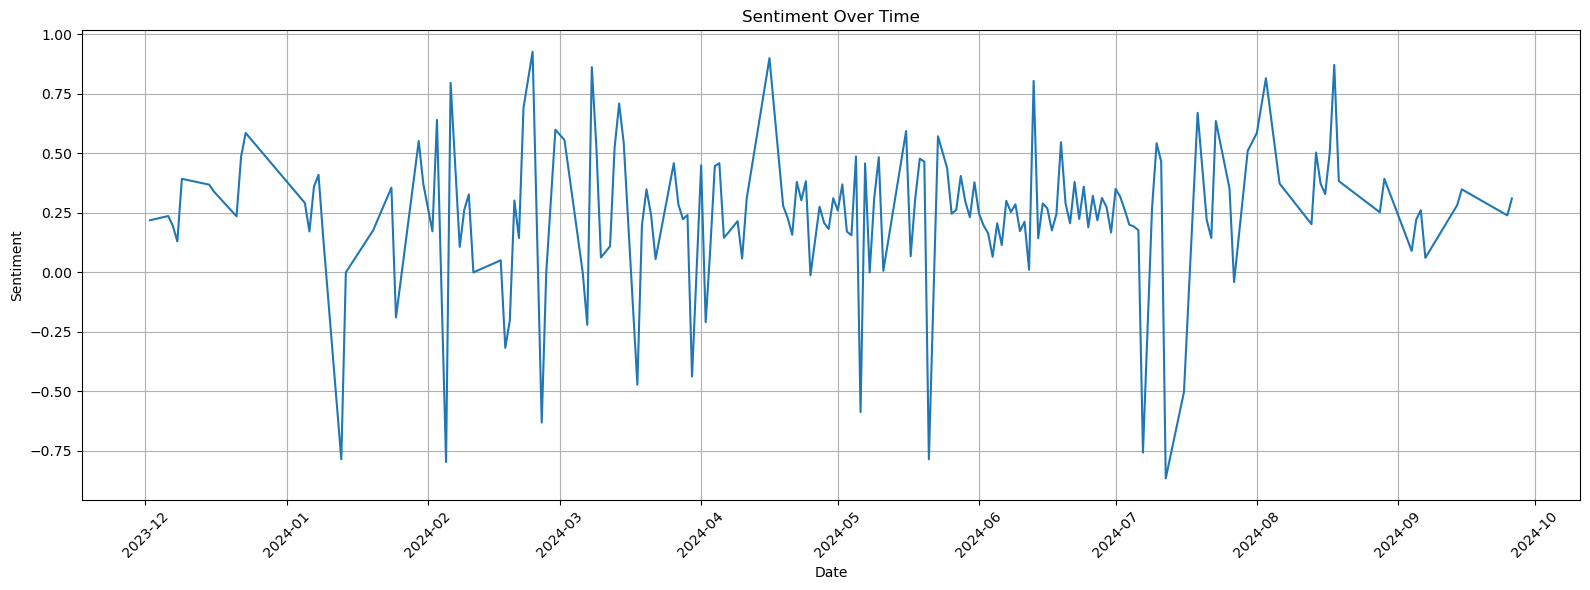

In [201]:
# sentiment for topic 1

topic_sentiments(topic1_words,start_date,end_date)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

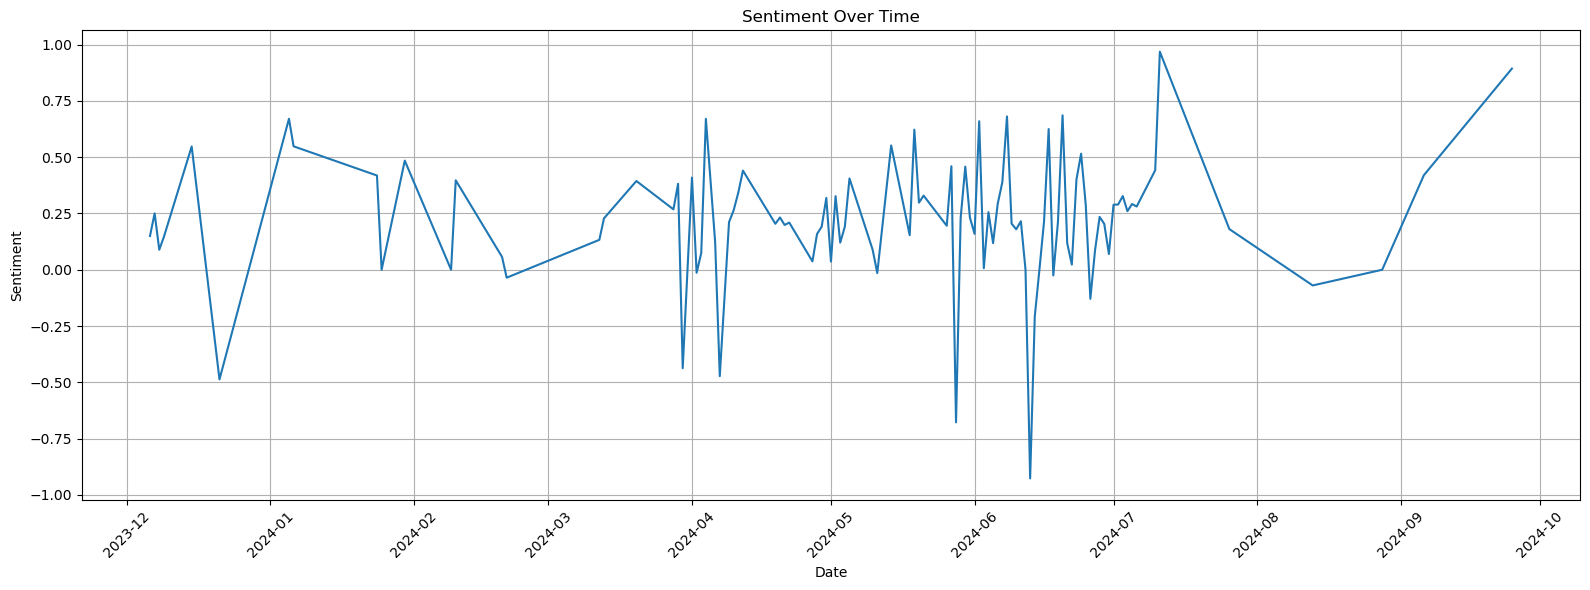

In [202]:
# sentiment for topic 2

topic_sentiments(topic2_words,start_date,end_date)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

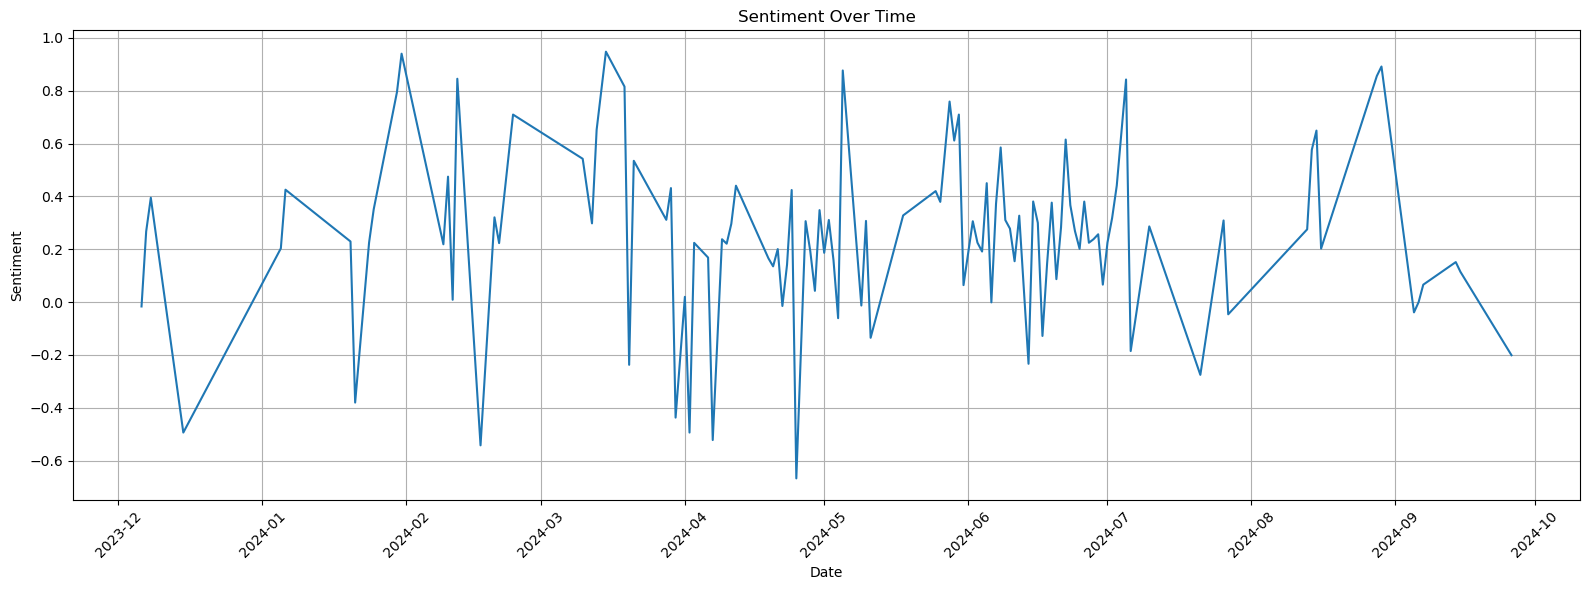

In [203]:
# sentiment for topic 4

topic_sentiments(topic4_words,start_date,end_date)

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

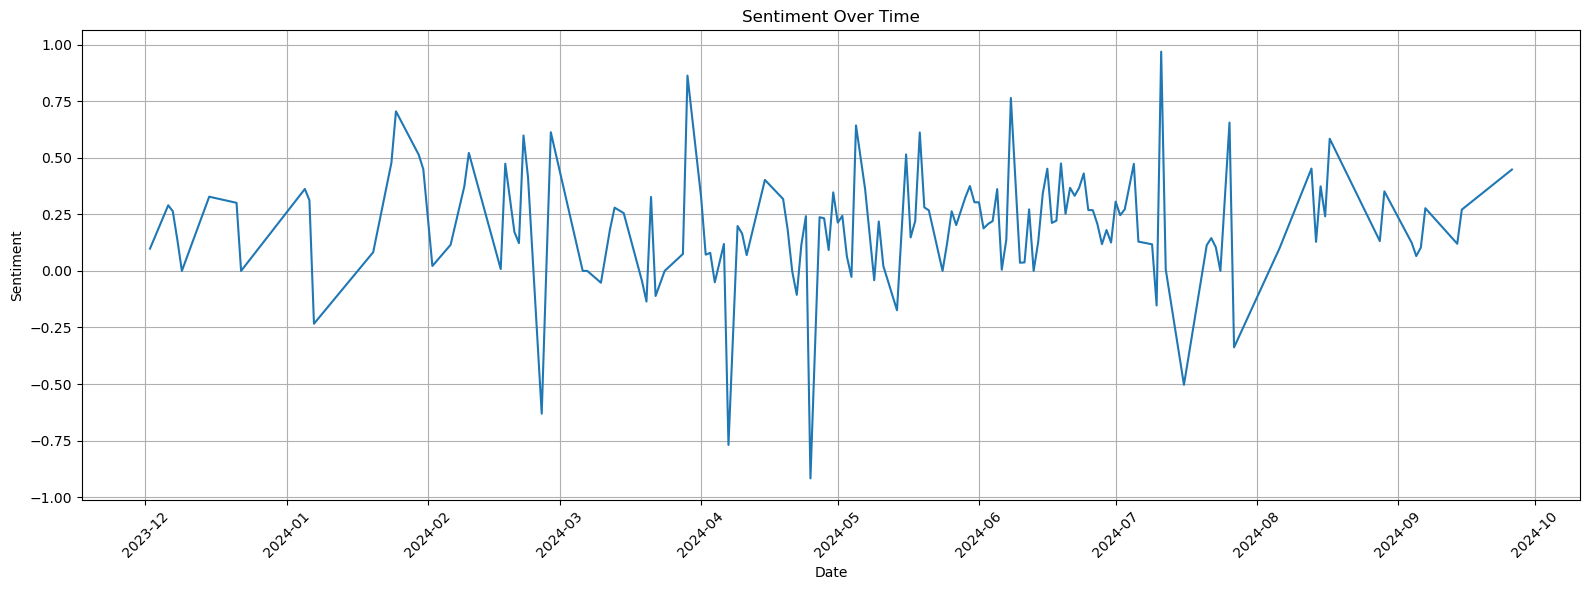

In [204]:
# sentiment for topic 5

topic_sentiments(topic5_words,start_date,end_date)

In [205]:
start_date = {'year': 2024, 'month': 6, 'day': 1}
end_date = {'year': 2024, 'month': 6, 'day': 30}

C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\sppag\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/79224 [00:00<?, ?it/s]

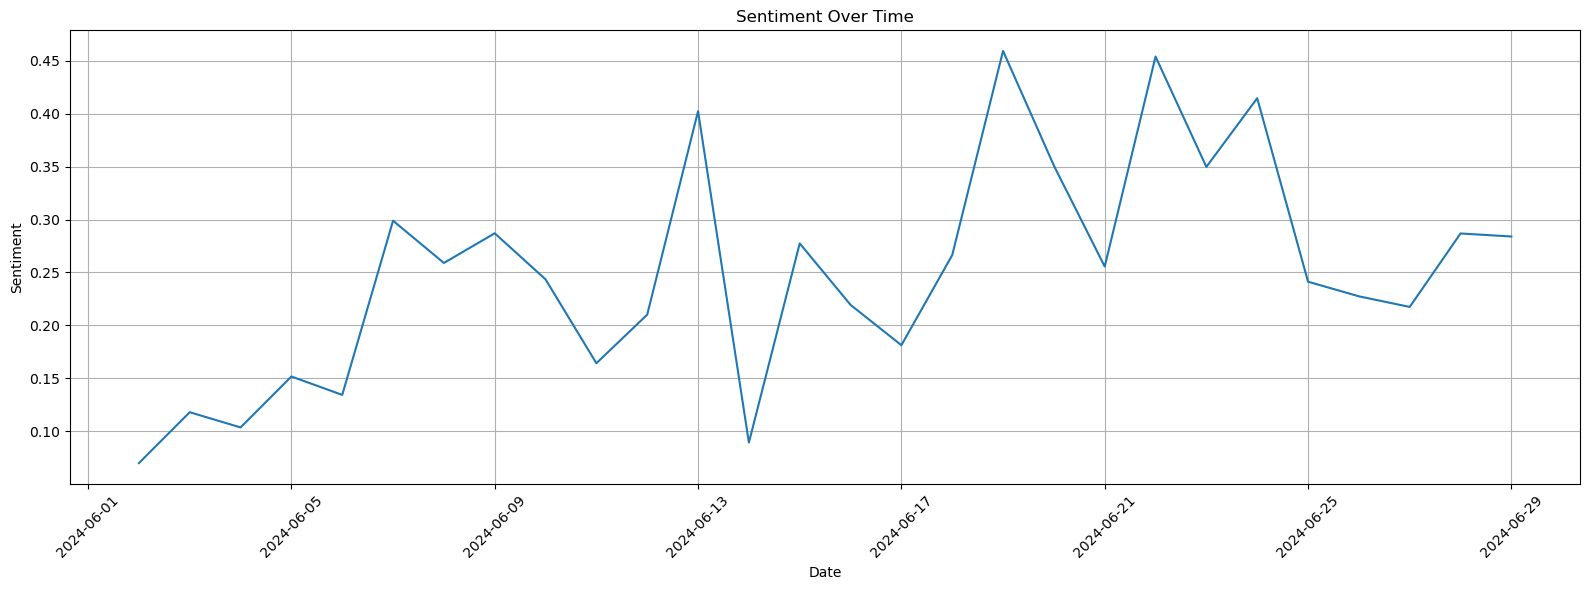

In [206]:
# sentiment for topic 3

topic_sentiments(topic3_words,start_date,end_date)

In [209]:
reddit_t20_df.head()

,Post_id,Id,Time,Author,Score,No_comments,Body,Type,Processed_1,Processed_2
0,1drh232,1drh232,2024-06-30,pluto_N,11118,1222,India are the champions of T20 World Cup 2024,Post,india champion world cup,India are the champions of T20 World Cup
1,1drh232,lav528s,2024-06-30,AssociationNo9219,2969,0,The death over bowling from India when 30 of 30 was needed is the type of nerves we needed under pressure,Comment,death bowling india need type nerve need pressure,The death over bowling from India when of was needed is the type of nerves we needed under pressure
2,1drh232,lav4wrb,2024-06-30,sherlockwm,1324,0,South Africa had just sniffed the cup and India took it away,Comment,south africa sniff cup india take away,South Africa had just sniffed the cup and India took it away
3,1drh232,lav55k3,2024-06-30,ghazilazi,1736,0,"I have no idea how India managed to come back from 30(30), but Jasprit Bumrah is a cheat code.",Comment,idea india manage come back jasprit bumrah cheat code,"I have no idea how India managed to come back from ( ) , but Jasprit Bumrah is a cheat code ."
4,1drh232,lav5kim,2024-06-30,Rytnix07,550,0,"The cruelty of sport. The two teams which came to the final were in drought for an ICC trophy. As an Indian I am overjoyed, and congrats to SA for such an amazing battle. \n\nSeeing Miller cry broke my heart, Stand proud SA you played so well.",Comment,cruelty sport two team come final drought icc trophy indian overjoy congrats sa amazing battle see miller cry break heart stand proud sa play well,"The cruelty of sport . The two teams which came to the final were in drought for an ICC trophy . As an Indian I am overjoyed , and congrats to SA for such an amazing battle . Seeing Miller cry broke my heart , Stand proud SA you played so well ."
